# Setup

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DataCollatorWithPadding, XLMRobertaConfig, XLMRobertaModel, get_linear_schedule_with_warmup
from transformers.modeling_utils import PretrainedConfig
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, naive_bayes, pipeline
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
import random
from nltk.corpus import stopwords
from gensim.utils import tokenize as tk
from gensim.models import Doc2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import TaggedDocument
from utils.functions import group_texts, lrn_code, topic_code,subcode_trans, extract_code,  party_deu
from utils.functions import train_loop, eval_loop, test_loop, tokenize_function, cmp_scale, scale_func
from utils.models import TLRRPredict
from sklearn.utils.class_weight import compute_class_weight
from safetensors.torch import load_file
import pickle
import nltk
#nltk.download('stopwords') ## Remove comments and do it once if you haven't

In [2]:
torch.cuda.empty_cache() 
device = torch.device('cuda')
torch.cuda.get_device_name(device=None)


'NVIDIA GeForce RTX 3090'

In [3]:
## Pseudo-randomness for reproducibility
seed_val = 1234
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)


# Implementation

### Data preparation

In [43]:
manifesto = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes.csv"), encoding="utf-8")

In [5]:
manifesto = manifesto[(manifesto.code.notna()) & ~(manifesto.code == 'H')].reset_index(drop=True)

In [6]:
manifesto['code_long'] = manifesto['code'].apply(subcode_trans)
manifesto['code_extract'] = manifesto['code_long'].astype(str).apply(extract_code)



In [7]:
manifesto['lrn'] = manifesto.apply(lambda x: lrn_code(x['code_long'], x['code_extract']), axis=1)
manifesto['topic'] = manifesto['code_extract'].apply(topic_code)

In [8]:
manifesto.groupby('lrn').count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,topic
lrn,,,,,,,,,,,,,
left,455675,455675,455675,455675,455675,455675,455675,455675,455675,455675,455675,455675,455675
neutral,263228,263228,263228,263228,263228,263228,263228,263228,263228,263228,263228,263228,263228
right,124419,124419,124419,124419,124419,124419,124419,124419,124419,124419,124419,124419,124419


In [9]:
manifesto.groupby('topic').count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn
topic,,,,,,,,,,,,,
Agriculture,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495
Civil Rights,98272,98272,98272,98272,98272,98272,98272,98272,98272,98272,98272,98272,98272
Decentralization,42834,42834,42834,42834,42834,42834,42834,42834,42834,42834,42834,42834,42834
Defense,14392,14392,14392,14392,14392,14392,14392,14392,14392,14392,14392,14392,14392
Economy,86409,86409,86409,86409,86409,86409,86409,86409,86409,86409,86409,86409,86409
Education,43364,43364,43364,43364,43364,43364,43364,43364,43364,43364,43364,43364,43364
Environment,91961,91961,91961,91961,91961,91961,91961,91961,91961,91961,91961,91961,91961
European integration,19567,19567,19567,19567,19567,19567,19567,19567,19567,19567,19567,19567,19567
Immigration,28729,28729,28729,28729,28729,28729,28729,28729,28729,28729,28729,28729,28729


In [10]:
len(manifesto[manifesto.lrn=="right"])/len(manifesto)*100 ## minority group: 14.8%

14.75343937428408

In [11]:
len(manifesto[manifesto.topic=="Defense"])/len(manifesto)*100 ## minority group: 1.7%

1.7065841991552457

In [12]:
texts = manifesto['text'].tolist()

In [13]:
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 17.97537002473551
Std length (word) is: 11.163519592598034
Min length (word) is: 1
Max length (word) is: 269


<Axes: >

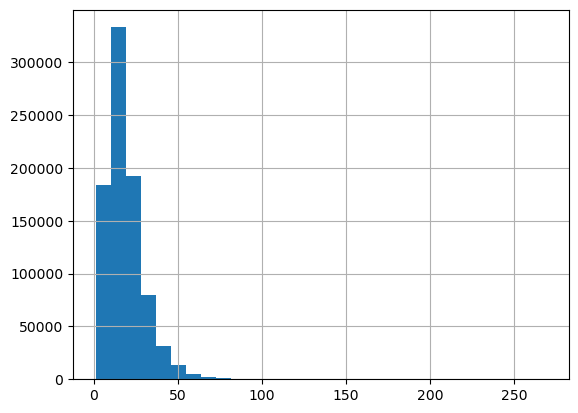

In [14]:
pd.Series(seq_len).hist(bins = 30)

In [15]:
results = group_texts(manifesto, 
                      ['countryname','election','party','code_long'], 'text', 
                      max_group_factor = 5)

In [16]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [17]:
df_cols = manifesto_regrouped['labels'].str.split('_', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)


In [18]:
manifesto_regrouped.columns = ['text', 'country_election_party_code', 'country','election', 'party', 'code_long']

In [19]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,code_long
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria_1999_42110_10400,Austria,1999,42110,10400
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria_1999_42110_10500,Austria,1999,42110,10500
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria_1999_42110_10500,Austria,1999,42110,10500
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria_1999_42110_10500,Austria,1999,42110,10500
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria_1999_42110_10500,Austria,1999,42110,10500


In [20]:
manifesto_regrouped['code_extract'] = manifesto_regrouped['code_long'].apply(extract_code)
manifesto_regrouped['lrn'] = manifesto_regrouped.apply(lambda x: lrn_code(x['code_long'], x['code_extract']), axis=1)
manifesto_regrouped['topic'] = manifesto_regrouped['code_extract'].apply(topic_code)


In [21]:
manifesto_regrouped.groupby('lrn').count()

,text,country_election_party_code,country,election,party,code_long,code_extract,topic
lrn,,,,,,,,
left,175291,175291,175291,175291,175291,175291,175291,175291
neutral,100466,100466,100466,100466,100466,100466,100466,100466
right,48517,48517,48517,48517,48517,48517,48517,48517


In [22]:
len(manifesto_regrouped)

324274

In [23]:
manifesto_regrouped = manifesto_regrouped.drop_duplicates().reset_index(drop=True)

In [24]:
len(manifesto_regrouped)

322330

In [25]:
texts = manifesto_regrouped['text'].tolist()
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 73.89117674433035
Std length (word) is: 36.83655233504344
Min length (word) is: 1
Max length (word) is: 374


<Axes: >

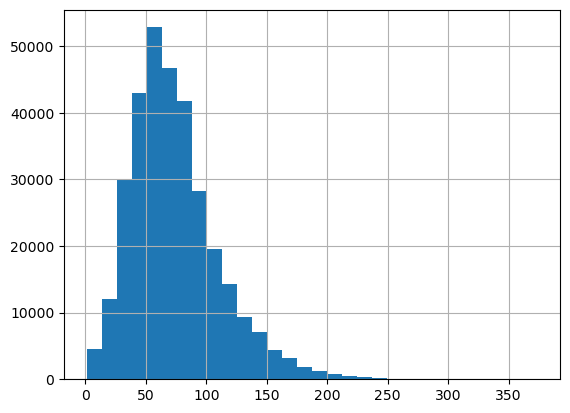

In [26]:
pd.Series(seq_len).hist(bins = 30)

In [27]:
len(np.where(np.array(seq_len)<5)[0])/len(manifesto_regrouped)*100

0.14984643067663575

In [28]:
rmv_idx = np.where(np.array(seq_len)<5)[0]

In [29]:
manifesto_regrouped = manifesto_regrouped.drop(rmv_idx).reset_index(drop=True)

In [30]:
texts = manifesto_regrouped['text'].tolist()
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 73.99732481582863
Std length (word) is: 36.762037687026606
Min length (word) is: 5
Max length (word) is: 374


<Axes: >

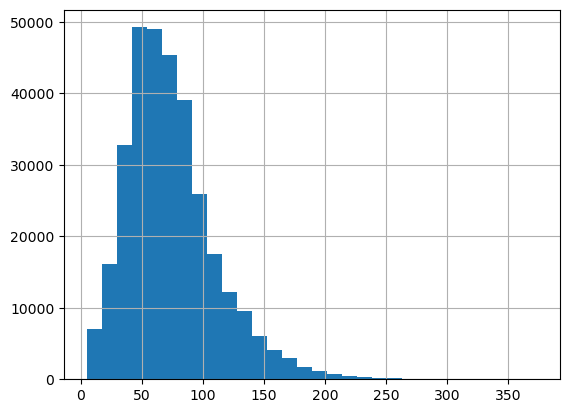

In [31]:
pd.Series(seq_len).hist(bins = 30)

In [32]:
manifesto_regrouped.to_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8', index=False)
manifesto.to_csv('data/temps/manifesto.csv', encoding='utf-8', index=False)

### Fine-tuning with manual left-right-neutral scheme (Kluever + CMP); grouped data

In [44]:
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8')
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')

In [45]:
manifesto_regrouped.groupby('lrn').count()

,text,country_election_party_code,country,election,party,code_long,code_extract,topic
lrn,,,,,,,,
left,174060,174060,174060,174060,174060,174060,174060,174060
neutral,99791,99791,99791,99791,99791,99791,99791,99791
right,47996,47996,47996,47996,47996,47996,47996,47996


In [35]:
manifesto_regrouped.groupby('topic').count()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn
topic,,,,,,,,
Agriculture,7956,7956,7956,7956,7956,7956,7956,7956
Civil Rights,37410,37410,37410,37410,37410,37410,37410,37410
Decentralization,16480,16480,16480,16480,16480,16480,16480,16480
Defense,5327,5327,5327,5327,5327,5327,5327,5327
Economy,33089,33089,33089,33089,33089,33089,33089,33089
Education,16707,16707,16707,16707,16707,16707,16707,16707
Environment,35039,35039,35039,35039,35039,35039,35039,35039
European integration,7725,7725,7725,7725,7725,7725,7725,7725
Immigration,10994,10994,10994,10994,10994,10994,10994,10994


In [46]:
manifesto_reduced = manifesto_regrouped[['topic','lrn','text']].reset_index(drop=True)

In [47]:
manifesto_reduced['topic_lrn'] = manifesto_reduced['topic'] + '_' + manifesto_reduced['lrn']

In [48]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [49]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('lrn')
manifesto_dataset = manifesto_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('topic_lrn')



Casting to class labels:   0%|          | 0/321847 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/321847 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/321847 [00:00<?, ? examples/s]

In [55]:
## Save class labels
import pickle
topic_labels = manifesto_dataset.features['topic'].names
file_path = 'data/temps/topic_labels'
with open(file_path, 'wb') as fp:
    pickle.dump(topic_labels, fp)

In [50]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='topic_lrn', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='topic_lrn', seed=seed_val )

In [51]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['topic', 'lrn', 'text', 'topic_lrn'],
        num_rows: 202763
    })
    test: Dataset({
        features: ['topic', 'lrn', 'text', 'topic_lrn'],
        num_rows: 32185
    })
    eval: Dataset({
        features: ['topic', 'lrn', 'text', 'topic_lrn'],
        num_rows: 86899
    })
})

In [53]:
train_set = manifesto_datasets['train'].to_pandas()
train_set.groupby('lrn').count()

,topic,text,topic_lrn
lrn,,,
0,109657,109657,109657
1,62868,62868,62868
2,30238,30238,30238


In [54]:
cw_lr = compute_class_weight(class_weight='balanced', classes = np.unique(train_set.lrn), y=train_set.lrn)
cw_lr

array([0.61635524, 1.07507264, 2.23518972])

In [44]:
cw_topic = compute_class_weight(class_weight='balanced', classes = np.unique(train_set.topic), y=train_set.topic)
cw_topic

array([3.37129223, 0.71691275, 1.62736364, 5.0348381 , 0.81055918,
       1.60525524, 0.76546691, 3.47244486, 2.43963567, 2.39978933,
       0.37317336, 0.39400529])

In [55]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 400}, 
                                            remove_columns=['text','topic_lrn'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/202763 [00:00<?, ? examples/s]

Map:   0%|          | 0/32185 [00:00<?, ? examples/s]

Map:   0%|          | 0/86899 [00:00<?, ? examples/s]

['topic', 'lrn', 'input_ids', 'attention_mask']

In [56]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=16, shuffle=False, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=16, shuffle=False, collate_fn = data_collator)

In [57]:
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

In [48]:
config

PretrainedConfig {
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "transformers_version": "4.38.1",
  "vocab_size": 250002
}

In [ ]:
topic_count = len(set(manifesto_regrouped['topic']))
lr_count = len(set(manifesto_regrouped['lrn']))
model = TLRRPredict(config, model_name, topic_count, lr_count, 
                    roberta_dim=config.hidden_size, per_topic_dim=1).to(device)


In [ ]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
loss_fn_topic = nn.CrossEntropyLoss(weight= torch.tensor(cw_topic, device=device).type(torch.float32))
loss_fn_lr = nn.CrossEntropyLoss(weight= torch.tensor(cw_lr, device=device).type(torch.float32))
loss_fn_reconstruct = nn.MSELoss()

In [ ]:
next(iter(train_dataloader))

{'topic': tensor([ 5,  8,  5,  4, 11,  4,  4,  1,  0,  5, 11,  1, 10,  8,  2, 10]), 'lrn': tensor([0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 0, 0, 1]), 'input_ids': tensor([[     0,    262, 101192,  ...,      1,      1,      1],
        [     0,    893, 101653,  ...,      1,      1,      1],
        [     0,   1413,  67097,  ...,      1,      1,      1],
        ...,
        [     0,  24812,     47,  ...,      1,      1,      1],
        [     0,  43945,      4,  ...,      1,      1,      1],
        [     0, 109134,    102,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct, device)
    eval_loop(eval_dataloader, model, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct, device)
 
    

Epoch: 1

Training...
loss: 1.535811  [16000/202763]. Took 0:03:14
loss: 1.376668  [32000/202763]. Took 0:06:26
loss: 1.229537  [48000/202763]. Took 0:09:41
loss: 1.132968  [64000/202763]. Took 0:12:55
loss: 1.068664  [80000/202763]. Took 0:16:08
loss: 1.020815  [96000/202763]. Took 0:19:22
loss: 0.983448  [112000/202763]. Took 0:22:33
loss: 0.952212  [128000/202763]. Took 0:25:43
loss: 0.926251  [144000/202763]. Took 0:28:53
loss: 0.905003  [160000/202763]. Took 0:32:01
loss: 0.886087  [176000/202763]. Took 0:35:07
loss: 0.868439  [192000/202763]. Took 0:38:20

  Training epoch took: 0:40:27
Test Error: 
 Accuracy: 73.8%, Avg loss: 0.608918 

Test Error: 
 Accuracy - LR: 72.0, Avg loss: 0.608918 

Test Error: 
 Accuracy - Topic: 75.6, Avg loss: 0.608918 

Epoch: 2

Training...
loss: 0.611784  [16000/202763]. Took 0:03:10
loss: 0.616568  [32000/202763]. Took 0:06:22
loss: 0.614685  [48000/202763]. Took 0:09:32
loss: 0.611871  [64000/202763]. Took 0:12:43
loss: 0.607681  [80000/202763].

In [ ]:
model.save_pretrained('results/multilingual/manifesto_tlrrp/')
tokenizer.save_pretrained('results/multilingual/manifesto_tlrrp/') 

('results/multilingual/manifesto_tlrrp/tokenizer_config.json',
 'results/multilingual/manifesto_tlrrp/special_tokens_map.json',
 'results/multilingual/manifesto_tlrrp/tokenizer.json')

### Scaling party positions in Germany

#### Reload files and compute LR-score by MARPOR for comparison

In [44]:
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8')

In [45]:
manifesto_deu = manifesto[manifesto.countryname == 'Germany'].reset_index(drop=True)
manifesto_deu_rgr = manifesto_regrouped[manifesto_regrouped.country == 'Germany'].reset_index(drop=True)

In [6]:
manifesto_deu_rgr.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic
0,Es ist Zeit für einen Wechsel Politik kann nic...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other
1,Die Bundesrepublik Deutschland ist von Zersied...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other
2,– einschließlich einer drastischen Reduzierung...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other
3,Sie schaffen nicht mehr Sicherheit Die Immunit...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other
4,Es ist zwar das schärfste Mittel gegen Straftä...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other


In [7]:
manifesto_deu.head()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn,topic
0,Es ist Zeit für einen Wechsel,1998,0.0,26,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,0,0,neutral,Other
1,"Die Bundesrepublik braucht eine neue, eine soz...",1998,303.0,27,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,30300,303,neutral,Other
2,Die Herausforderungen eines neuen Jahrhunderts...,1998,303.0,28,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,30300,303,neutral,Other
3,Politik kann nicht alle Probleme lösen,1998,0.0,29,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,0,0,neutral,Other
4,Aber Politik muß ihren Teil zur Lösung der Pro...,1998,0.0,30,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,0,0,neutral,Other


In [42]:
lr_kws = dict({'left': 'left', 'right': 'right'})

In [46]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu, text_var = 'text', group_vars=['party','election'], lr_kws = lr_kws, sent_var='lrn')

#### Scaling positions with ContextScale

In [9]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)


In [10]:
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

In [11]:
topic_count = len(set(manifesto_deu_rgr['topic']))
lr_count = len(set(manifesto_deu_rgr['lrn']))

In [12]:
## Load pre-trained models
model = TLRRPredict(config, model_name, topic_count, lr_count).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_tlrrp/model.safetensors')
model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [13]:
manifesto_reduced = manifesto_deu_rgr[['topic','lrn','text']].reset_index(drop=True)

In [14]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('lrn')
manifesto_dataset = manifesto_dataset.class_encode_column('topic')



Casting to class labels:   0%|          | 0/30955 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/30955 [00:00<?, ? examples/s]

In [15]:
tokenized_dataset = manifesto_dataset.map(tokenize_function, fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 400}, remove_columns=['text'])
tokenized_dataset.set_format("torch")

Map:   0%|          | 0/30955 [00:00<?, ? examples/s]

In [16]:
full_dataloader = DataLoader(tokenized_dataset, batch_size=32, shuffle=False, collate_fn = data_collator)

In [17]:
pred_topics, position_scores = scale_func(full_dataloader, model, device=device)

Start predicting labels...


In [34]:
manifesto_deu_rgr['lr_score'] = position_scores.flatten()
manifesto_deu_rgr['pred_topics'] = pred_topics

In [35]:
manifesto_deu_rgr[manifesto_deu_rgr['lrn'] == 'right']

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,lr_score,pred_topics
7,Ihnen war die Rettung der im Kalten Krieg ents...,Germany_1998_41113_10400,Germany,1998,41113,10400,104,right,Defense,0.911929,3
39,Mehr Demokratie und demokratische Kontrolle fo...,Germany_1998_41113_11000,Germany,1998,41113,11000,110,right,European integration,0.704039,7
40,Der Nachfolgevertrag von Amsterdam ist hinter ...,Germany_1998_41113_11000,Germany,1998,41113,11000,110,right,European integration,0.069761,7
73,Die Regierung behindert ihr eigenes Ziel der E...,Germany_1998_41113_20300,Germany,1998,41113,20300,203,right,Civil Rights,0.939495,7
79,Das Recht auf Bildungsurlaub muß in allen Bund...,Germany_1998_41113_30200,Germany,1998,41113,30200,302,right,Decentralization,0.693544,2
...,...,...,...,...,...,...,...,...,...,...,...
30921,Die AfD fordert: Bei qualifizierten Zuwanderer...,Germany_2021_41953_60820,Germany,2021,41953,60820,608,right,Immigration,0.923799,8
30922,Dies betrachten wir als eine der wichtigsten B...,Germany_2021_41953_60820,Germany,2021,41953,60820,608,right,Immigration,0.897856,8
30923,Da die islamischen Gemeinschaften in Deutschla...,Germany_2021_41953_60820,Germany,2021,41953,60820,608,right,Immigration,0.554066,8
30924,Viele dieser Vereine stehen unserer freiheitli...,Germany_2021_41953_60820,Germany,2021,41953,60820,608,right,Immigration,0.752276,8


In [20]:
columns  =['party', 'election','mean_score', 'se_score']
df = pd.DataFrame(columns=columns)

for name, group in manifesto_deu_rgr.groupby(['party','election']):
    mean_score = group['lr_score'].mean()
    se_score = group['lr_score'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_score, se_score]], columns = columns)
    df = (df_temp if df.empty else pd.concat([df, df_temp], ignore_index=True))

In [21]:
df

,party,election,mean_score,se_score
0,41113,1998,0.349805,0.012893
1,41113,2002,0.423349,0.017037
2,41113,2005,0.409251,0.017390
3,41113,2009,0.433666,0.010787
4,41113,2013,0.347103,0.008693
5,41113,2017,0.333691,0.010364
6,41113,2021,0.348453,0.009221
7,41221,1998,0.411313,0.019646
8,41221,2002,0.327135,0.020146
9,41222,2005,0.352861,0.022822


In [33]:
df['lr_log'] = logscale
df['lr_abs'] = absscale

In [34]:
np.corrcoef(df['lr_abs'], df['mean_score'])

array([[1.        , 0.90383148],
       [0.90383148, 1.        ]])

In [35]:
df.loc[:,'party_name'] = df['party'].apply(party_deu)
df = df[df.party_name != 'Other']
df.loc[:,'election'] = df['election'].astype(int)

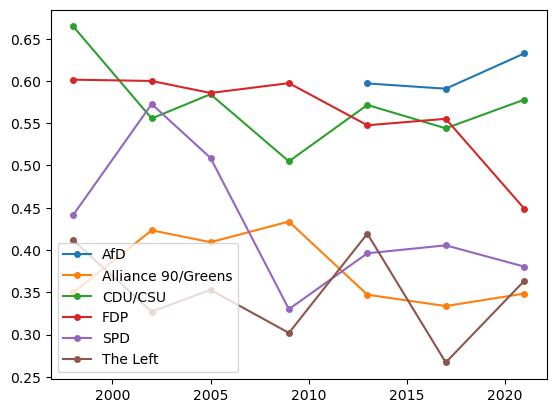

In [38]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party_name'):
    ax.plot(group.election, group.mean_score, marker='o',  ms=4, label=name)
ax.legend()

plt.show()

In [36]:
manifesto_deu_rgr.loc[:, 'pred_topics'] = manifesto_deu_rgr['pred_topics'].astype(int)


In [37]:
with open("data/temps/topic_labels", "rb") as fp:   # Unpickling
   topic_labels = pickle.load(fp)

In [38]:
name_topic_dict = dict([(x,y) for x,y in enumerate(topic_labels)])
name_topic_dict

{0: 'Agriculture',
 1: 'Civil Rights',
 2: 'Decentralization',
 3: 'Defense',
 4: 'Economy',
 5: 'Education',
 6: 'Environment',
 7: 'European integration',
 8: 'Immigration',
 9: 'International politics',
 10: 'Other',
 11: 'Social Welfare'}

In [39]:
manifesto_deu_rgr.loc[:, 'pred_topic_name']= manifesto_deu_rgr['pred_topics'].map(name_topic_dict)

In [40]:
manifesto_deu_rgr

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,lr_score,pred_topics,pred_topic_name
0,Es ist Zeit für einen Wechsel Politik kann nic...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,0.878013,2,Decentralization
1,Die Bundesrepublik Deutschland ist von Zersied...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,0.816113,10,Other
2,– einschließlich einer drastischen Reduzierung...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,0.643914,10,Other
3,Sie schaffen nicht mehr Sicherheit Die Immunit...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,0.891812,1,Civil Rights
4,Es ist zwar das schärfste Mittel gegen Straftä...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,0.894795,1,Civil Rights
...,...,...,...,...,...,...,...,...,...,...,...,...
30950,Die Hälfte der niedergelassenen Ärzte erreicht...,Germany_2021_41953_70400,Germany,2021,41953,70400,704,neutral,Other,0.849971,10,Other
30951,3. Finanzielle und organisatorische Niederlass...,Germany_2021_41953_70400,Germany,2021,41953,70400,704,neutral,Other,0.182428,11,Social Welfare
30952,Die AfD bekennt sich ausdrücklich zur Fürsor...,Germany_2021_41953_70500,Germany,2021,41953,70500,705,left,Civil Rights,0.062486,1,Civil Rights
30953,Um echte Teilhabe für behinderte Menschen am ...,Germany_2021_41953_70500,Germany,2021,41953,70500,705,left,Civil Rights,0.047597,1,Civil Rights


In [41]:
manifesto_deu_rgr.to_csv("data/py_outputs/cs_germany.csv", index=False)

## Position scores for all countries

In [ ]:
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')

# Validity checks

### Same dataset

#### Test set

In [42]:
## Load pre-trained models
model = TLRRPredict(config, model_name, topic_count, lr_count).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_tlrrp/model.safetensors')
model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [61]:
pred_topics, pred_sent = test_loop(test_dataloader, model, device=device)

In [62]:
predicted_topics = np.concatenate([i.cpu().detach().numpy() for i in pred_topics])
predicted_sent = np.concatenate([i.cpu().detach().numpy() for i in pred_sent])

In [63]:
test_set = manifesto_datasets['test'].to_pandas()

In [64]:
labels = test_set['topic'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_topics, average=None)
matrix = confusion_matrix(labels, predicted_topics)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [65]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.84,0.81,0.88,0.88
1,0.82,0.81,0.84,0.84
2,0.83,0.81,0.85,0.85
3,0.90,0.89,0.91,0.91
4,0.80,0.77,0.83,0.83
5,0.89,0.86,0.92,0.92
6,0.89,0.88,0.89,0.89
7,0.88,0.87,0.90,0.90
8,0.80,0.77,0.83,0.83
9,0.85,0.83,0.87,0.87


In [66]:
round(res_table.mean(axis=0),2)

f1           0.85
precision    0.84
recall       0.86
accuracy     0.86
dtype: float64

In [67]:
list_names = manifesto_datasets['train'].features['topic'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'Agriculture',
 1: 'Civil Rights',
 2: 'Decentralization',
 3: 'Defense',
 4: 'Economy',
 5: 'Education',
 6: 'Environment',
 7: 'European integration',
 8: 'Immigration',
 9: 'International politics',
 10: 'Other',
 11: 'Social Welfare'}

In [68]:
res_table['topic_name'] = pd.Series(res_table.index.values).map(name_topic_dict)
res_table

,f1,precision,recall,accuracy,topic_name
0,0.84,0.81,0.88,0.88,Agriculture
1,0.82,0.81,0.84,0.84,Civil Rights
2,0.83,0.81,0.85,0.85,Decentralization
3,0.90,0.89,0.91,0.91,Defense
4,0.80,0.77,0.83,0.83,Economy
5,0.89,0.86,0.92,0.92,Education
6,0.89,0.88,0.89,0.89,Environment
7,0.88,0.87,0.90,0.90,European integration
8,0.80,0.77,0.83,0.83,Immigration
9,0.85,0.83,0.87,0.87,International politics


In [69]:
labels = test_set['lrn'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_sent, average=None)
matrix = confusion_matrix(labels, predicted_sent)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [70]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.89,0.91,0.88,0.88
1,0.86,0.84,0.87,0.87
2,0.76,0.74,0.78,0.78


In [71]:
round(res_table.mean(axis=0),2)

f1           0.84
precision    0.83
recall       0.84
accuracy     0.84
dtype: float64

In [72]:
list_names = manifesto_datasets['train'].features['lrn'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'left', 1: 'neutral', 2: 'right'}

In [73]:
res_table['lrn'] = pd.Series(res_table.index.values).map(name_topic_dict)
res_table

,f1,precision,recall,accuracy,lrn
0,0.89,0.91,0.88,0.88,left
1,0.86,0.84,0.87,0.87,neutral
2,0.76,0.74,0.78,0.78,right


#### Different language 

### COALITIONAGREE, same coding style

In [4]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [5]:
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

#### No supervision

In [12]:
coalitionagree = pd.read_csv('data/r_outputs/coalitionagree_texts.csv', encoding='utf-8', index_col=0).reset_index(drop=True)

In [7]:
results = group_texts(coalitionagree, ['country','cabinet_year','category3'], 'sentence', max_group_factor = 5)

In [8]:
coalition_regrouped = pd.DataFrame(results)
coalition_regrouped = coalition_regrouped.explode('text').reset_index(drop=True)
df_cols = coalition_regrouped['labels'].str.split('_', expand=True)
coalition_regrouped = pd.concat([coalition_regrouped, df_cols], axis=1)
coalition_regrouped.columns =['text','labels', 'country','year', 'code']
coalition_regrouped['code_short'] = coalition_regrouped['code'].apply(extract_code)

In [187]:
coalition_regrouped.head()

,text,labels,country,year,code,code_short
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria_1945_30301,Austria,1945,30301,303
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria_1945_30303,Austria,1945,30303,303
2,über die Behandlung der Nationalsozialisten,Austria_1945_30506,Austria,1945,30506,305
3,sowie über die Verstaatlichung werden in Aussi...,Austria_1945_41301,Austria,1945,41301,413
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria_1945_50602,Austria,1945,50602,506


In [9]:
coalition_regrouped['lrn'] = coalition_regrouped.apply(lambda x: lrn_code(x['code'], x['code_short']), axis=1)
coalition_regrouped['topic'] = coalition_regrouped['code_short'].apply(topic_code)

In [190]:
coalition_regrouped.groupby('lrn').count()

,text,labels,country,year,code,code_short,coalition_topic,topic
lrn,,,,,,,,
left,17997,17997,17997,17997,17997,17997,17997,17997
neutral,15257,15257,15257,15257,15257,15257,15257,15257
right,6033,6033,6033,6033,6033,6033,6033,6033


In [194]:
coalition_regrouped

,text,labels,country,year,code,code_short,lrn,topic
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria_1945_30301,Austria,1945,30301,303,neutral,Other
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria_1945_30303,Austria,1945,30303,303,neutral,Other
2,über die Behandlung der Nationalsozialisten,Austria_1945_30506,Austria,1945,30506,305,right,Decentralization
3,sowie über die Verstaatlichung werden in Aussi...,Austria_1945_41301,Austria,1945,41301,413,left,Economy
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria_1945_50602,Austria,1945,50602,506,left,Education
...,...,...,...,...,...,...,...,...
39282,Sverige ska säkra de nationella minoriteternas...,Sweden_2014_70501,Sweden,2014,70501,705,left,Civil Rights
39283,Personer med funktionsnedsättning ska ha möjli...,Sweden_2014_70502,Sweden,2014,70502,705,left,Civil Rights
39284,hbtq-personer,Sweden_2014_70503,Sweden,2014,70503,705,left,Civil Rights
39285,"särskilt kvinnor, Insatser för kvinnors egenfö...",Sweden_2014_70602,Sweden,2014,70602,706,left,Civil Rights


In [10]:
cagree_reduced = coalition_regrouped[['lrn', 'topic','text']]

In [13]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('lrn')
cagree_dataset = cagree_dataset.class_encode_column('topic')


Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [14]:
tokenized_dataset = cagree_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 400}, 
                                            remove_columns=['text'])

Map:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [15]:
full_dataloader = DataLoader(tokenized_dataset, batch_size=32, shuffle=False, collate_fn = data_collator)

In [204]:
## Load pre-trained models
topic_count = len(set(cagree_reduced['topic']))
lr_count = len(set(cagree_reduced['lrn']))
model = TLRRPredict(config, model_name, topic_count, lr_count).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_tlrrp/model.safetensors')
model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [206]:
pred_topics, pred_lrn = test_loop(full_dataloader, model, device=device)

In [208]:
predicted_topics = np.concatenate([i.cpu().detach().numpy() for i in pred_topics])
predicted_lrn = np.concatenate([i.cpu().detach().numpy() for i in pred_lrn])

In [210]:
test_set = cagree_dataset.to_pandas()

In [211]:
labels = test_set['topic'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_topics, average=None)
matrix = confusion_matrix(labels, predicted_topics)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [212]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.74,0.67,0.81,0.81
1,0.70,0.66,0.75,0.75
2,0.51,0.43,0.65,0.65
3,0.79,0.81,0.77,0.77
4,0.67,0.62,0.73,0.73
5,0.76,0.75,0.77,0.77
6,0.77,0.77,0.78,0.78
7,0.74,0.73,0.76,0.76
8,0.64,0.61,0.69,0.69
9,0.78,0.72,0.86,0.86


In [213]:
round(res_table.mean(axis=0),2)

f1           0.71
precision    0.69
recall       0.74
accuracy     0.74
dtype: float64

In [215]:
list_names = cagree_dataset.features['topic'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'Agriculture',
 1: 'Civil Rights',
 2: 'Decentralization',
 3: 'Defense',
 4: 'Economy',
 5: 'Education',
 6: 'Environment',
 7: 'European integration',
 8: 'Immigration',
 9: 'International politics',
 10: 'Other',
 11: 'Social Welfare'}

In [216]:
res_table['topic_name'] = pd.Series(res_table.index.values).map(name_topic_dict)
res_table

,f1,precision,recall,accuracy,topic_name
0,0.74,0.67,0.81,0.81,Agriculture
1,0.70,0.66,0.75,0.75,Civil Rights
2,0.51,0.43,0.65,0.65,Decentralization
3,0.79,0.81,0.77,0.77,Defense
4,0.67,0.62,0.73,0.73,Economy
5,0.76,0.75,0.77,0.77,Education
6,0.77,0.77,0.78,0.78,Environment
7,0.74,0.73,0.76,0.76,European integration
8,0.64,0.61,0.69,0.69,Immigration
9,0.78,0.72,0.86,0.86,International politics


In [219]:
labels = test_set['lrn'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_lrn, average=None)
matrix = confusion_matrix(labels, predicted_lrn)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [220]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.77,0.79,0.75,0.75
1,0.75,0.75,0.75,0.75
2,0.60,0.56,0.65,0.65


In [221]:
round(res_table.mean(axis=0),2)

f1           0.71
precision    0.70
recall       0.72
accuracy     0.72
dtype: float64

In [222]:
list_names = cagree_dataset.features['lrn'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'left', 1: 'neutral', 2: 'right'}

In [223]:
res_table['lrn'] = pd.Series(res_table.index.values).map(name_topic_dict)
res_table

,f1,precision,recall,accuracy,lrn
0,0.77,0.79,0.75,0.75,left
1,0.75,0.75,0.75,0.75,neutral
2,0.60,0.56,0.65,0.65,right


#### 25% supervision

In [13]:
cagree_reduced.loc[:,'topic_lrn'] = cagree_reduced.loc[:,'topic'] + '_' + cagree_reduced.loc[:,'lrn']

In [14]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('lrn')
cagree_dataset = cagree_dataset.class_encode_column('topic')
cagree_dataset = cagree_dataset.class_encode_column('topic_lrn')

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [15]:
train_test = cagree_dataset.train_test_split(test_size=0.75, stratify_by_column='topic_lrn', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.2, stratify_by_column='topic_lrn', seed=seed_val )

In [16]:
cagree_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
cagree_datasets

DatasetDict({
    train: Dataset({
        features: ['lrn', 'topic', 'text', 'topic_lrn'],
        num_rows: 7856
    })
    test: Dataset({
        features: ['lrn', 'topic', 'text', 'topic_lrn'],
        num_rows: 29466
    })
    eval: Dataset({
        features: ['lrn', 'topic', 'text', 'topic_lrn'],
        num_rows: 1965
    })
})

In [17]:
train_set = cagree_datasets['train'].to_pandas()
train_set.groupby('lrn').count()

,topic,text,topic_lrn
lrn,,,
0,3598,3598,3598
1,3050,3050,3050
2,1208,1208,1208


In [18]:
cw_lr = compute_class_weight(class_weight='balanced', classes = np.unique(train_set.lrn), y=train_set.lrn)
cw_lr

array([0.72781175, 0.85857923, 2.16777042])

In [19]:
cw_topic = compute_class_weight(class_weight='balanced', classes = np.unique(train_set.topic), y=train_set.topic)
cw_topic

array([3.39205527, 0.95711501, 1.97188755, 3.65735568, 0.70928133,
       1.70486111, 1.04412547, 3.42757417, 3.57741348, 2.22675737,
       0.27153325, 0.44994273])

In [20]:
tokenized_datasets = cagree_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 400}, 
                                            remove_columns=['text','topic_lrn'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/7856 [00:00<?, ? examples/s]

Map:   0%|          | 0/29466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1965 [00:00<?, ? examples/s]

['lrn', 'topic', 'input_ids', 'attention_mask']

In [21]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=16, shuffle=False, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=16, shuffle=False, collate_fn = data_collator)

In [22]:
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

In [244]:
## Load pre-trained models
topic_count = len(set(cagree_reduced['topic']))
lr_count = len(set(cagree_reduced['lrn']))
model = TLRRPredict(config, model_name, topic_count, lr_count).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_tlrrp/model.safetensors')
model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [245]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
loss_fn_topic = nn.CrossEntropyLoss(weight= torch.tensor(cw_topic, device=device).type(torch.float32))
loss_fn_lr = nn.CrossEntropyLoss(weight= torch.tensor(cw_lr, device=device).type(torch.float32))
loss_fn_reconstruct = nn.MSELoss()

In [246]:
next(iter(train_dataloader))

{'lrn': tensor([0, 1, 1, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 1]), 'topic': tensor([11, 10, 10, 11, 10, 11,  6, 11,  5,  4,  6,  4,  4,  1, 11,  0]), 'input_ids': tensor([[     0,     22,  74954,  ...,      1,      1,      1],
        [     0,  38245,   1446,  ...,      1,      1,      1],
        [     0,     79,   9408,  ...,     66,      5,      2],
        ...,
        [     0,    122,  24641,  ...,      1,      1,      1],
        [     0,  44891,    329,  ...,      1,      1,      1],
        [     0, 129551,    538,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [247]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct, device)
    eval_loop(eval_dataloader, model, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct, device)
 
    

Epoch: 1

Training...

  Training epoch took: 0:01:32
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.497511 

Test Error: 
 Accuracy - LR: 80.5, Avg loss: 0.497511 

Test Error: 
 Accuracy - Topic: 77.3, Avg loss: 0.497511 

Epoch: 2

Training...

  Training epoch took: 0:01:31
Test Error: 
 Accuracy: 81.3%, Avg loss: 0.484321 

Test Error: 
 Accuracy - LR: 81.8, Avg loss: 0.484321 

Test Error: 
 Accuracy - Topic: 80.8, Avg loss: 0.484321 

Epoch: 3

Training...

  Training epoch took: 0:01:27
Test Error: 
 Accuracy: 81.8%, Avg loss: 0.490456 

Test Error: 
 Accuracy - LR: 83.1, Avg loss: 0.490456 

Test Error: 
 Accuracy - Topic: 80.6, Avg loss: 0.490456 

Epoch: 4

Training...

  Training epoch took: 0:01:28
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.511203 

Test Error: 
 Accuracy - LR: 84.3, Avg loss: 0.511203 

Test Error: 
 Accuracy - Topic: 82.1, Avg loss: 0.511203 

Epoch: 5

Training...

  Training epoch took: 0:01:27
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.518048 

Test Error

In [248]:
model.save_pretrained('results/multilingual/cagree_tlrrp/')
tokenizer.save_pretrained('results/multilingual/cagree_tlrrp/') 

('results/multilingual/cagree_tlrrp/tokenizer_config.json',
 'results/multilingual/cagree_tlrrp/special_tokens_map.json',
 'results/multilingual/cagree_tlrrp/tokenizer.json')

In [11]:
## Load pre-trained models
topic_count = len(set(cagree_reduced['topic']))
lr_count = len(set(cagree_reduced['lrn']))
model = TLRRPredict(config, model_name, topic_count, lr_count).to(device)
loaded_tensors = load_file('results/multilingual/cagree_tlrrp/model.safetensors')
model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [24]:
pred_topics, pred_sent = test_loop(test_dataloader, model, device=device)

In [25]:
predicted_topics = np.concatenate([i.cpu().detach().numpy() for i in pred_topics])
predicted_sent = np.concatenate([i.cpu().detach().numpy() for i in pred_sent])

In [26]:
test_set = cagree_datasets['test'].to_pandas()

In [27]:
labels = test_set['topic'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_topics, average=None)
matrix = confusion_matrix(labels, predicted_topics)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [28]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.81,0.76,0.87,0.87
1,0.79,0.73,0.85,0.85
2,0.71,0.69,0.74,0.74
3,0.88,0.86,0.90,0.90
4,0.77,0.76,0.77,0.77
5,0.87,0.84,0.90,0.90
6,0.85,0.83,0.87,0.87
7,0.85,0.82,0.88,0.88
8,0.75,0.72,0.78,0.78
9,0.86,0.84,0.87,0.87


In [29]:
round(res_table.mean(axis=0),2)

f1           0.82
precision    0.80
recall       0.84
accuracy     0.84
dtype: float64

In [30]:
list_names = cagree_datasets['train'].features['topic'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'Agriculture',
 1: 'Civil Rights',
 2: 'Decentralization',
 3: 'Defense',
 4: 'Economy',
 5: 'Education',
 6: 'Environment',
 7: 'European integration',
 8: 'Immigration',
 9: 'International politics',
 10: 'Other',
 11: 'Social Welfare'}

In [31]:
res_table['topic_name'] = pd.Series(res_table.index.values).map(name_topic_dict)
res_table

,f1,precision,recall,accuracy,topic_name
0,0.81,0.76,0.87,0.87,Agriculture
1,0.79,0.73,0.85,0.85,Civil Rights
2,0.71,0.69,0.74,0.74,Decentralization
3,0.88,0.86,0.90,0.90,Defense
4,0.77,0.76,0.77,0.77,Economy
5,0.87,0.84,0.90,0.90,Education
6,0.85,0.83,0.87,0.87,Environment
7,0.85,0.82,0.88,0.88,European integration
8,0.75,0.72,0.78,0.78,Immigration
9,0.86,0.84,0.87,0.87,International politics


In [32]:
labels = test_set['lrn'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_sent, average=None)
matrix = confusion_matrix(labels, predicted_sent)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [33]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.87,0.87,0.86,0.86
1,0.87,0.87,0.88,0.88
2,0.72,0.72,0.71,0.71


In [34]:
round(res_table.mean(axis=0),2)

f1           0.82
precision    0.82
recall       0.82
accuracy     0.82
dtype: float64

In [36]:
list_names = cagree_datasets['train'].features['lrn'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'left', 1: 'neutral', 2: 'right'}

In [37]:
res_table['lrn'] = pd.Series(res_table.index.values).map(name_topic_dict)
res_table

,f1,precision,recall,accuracy,lrn
0,0.87,0.87,0.86,0.86,left
1,0.87,0.87,0.88,0.88,neutral
2,0.72,0.72,0.71,0.71,right


#### Scale the entire corpus with 25% training

In [16]:
## Load pre-trained models
topic_count = len(set(cagree_reduced['topic']))
lr_count = len(set(cagree_reduced['lrn']))
model = TLRRPredict(config, model_name, topic_count, lr_count).to(device)
loaded_tensors = load_file('results/multilingual/cagree_tlrrp/model.safetensors')
model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [17]:
pred_topics, position_scores, pred_lrs = scale_func(full_dataloader, model, device=device, anchor_prob=[[1.0, 0.0, 0.0]])

Start predicting labels...


In [20]:
coalition_regrouped.loc[:,'position_scores'] = position_scores.flatten()
coalition_regrouped.loc[:,'pred_topics'] = pred_topics
coalition_regrouped.loc[:,'cs_pred_25'] = pred_lrs



In [21]:
labels = cagree_dataset['lrn']
precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_lrs, average=None)
matrix = confusion_matrix(labels, pred_lrs)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [22]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.88,0.89,0.88,0.88
1,0.89,0.89,0.90,0.90
2,0.76,0.76,0.76,0.76


In [23]:
coalition_regrouped.head()

,text,labels,country,year,code,code_short,lrn,topic,position_scores,pred_topics,cs_pred_25
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria_1945_30301,Austria,1945,30301,303,neutral,Other,0.840121,10,1
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria_1945_30303,Austria,1945,30303,303,neutral,Other,0.078758,1,0
2,über die Behandlung der Nationalsozialisten,Austria_1945_30506,Austria,1945,30506,305,right,Decentralization,0.563922,8,2
3,sowie über die Verstaatlichung werden in Aussi...,Austria_1945_41301,Austria,1945,41301,413,left,Economy,0.385411,1,1
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria_1945_50602,Austria,1945,50602,506,left,Education,0.071691,5,0


In [24]:
coalition_regrouped.to_csv('data/py_outputs/cagree_scaled.csv', index=False)

### Trump dataset, different coding style

#### Adaptation training - 25%

In [5]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

In [36]:
motn_trump = pd.read_csv('data/MOTN/MOTN_responses_groundtruth.csv')

In [7]:
motn_trump_reduced = motn_trump[['edits_clean_text','trump_stance_auto']]

In [8]:
motn_dataset = Dataset.from_pandas(motn_trump_reduced)
motn_dataset = motn_dataset.class_encode_column('trump_stance_auto')


Stringifying the column:   0%|          | 0/7146 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/7146 [00:00<?, ? examples/s]

In [7]:
train_test = motn_dataset.train_test_split(test_size=0.75, stratify_by_column='trump_stance_auto', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.2, stratify_by_column='trump_stance_auto', seed=seed_val )

In [8]:
motn_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
motn_datasets

DatasetDict({
    train: Dataset({
        features: ['edits_clean_text', 'trump_stance_auto'],
        num_rows: 1428
    })
    test: Dataset({
        features: ['edits_clean_text', 'trump_stance_auto'],
        num_rows: 5360
    })
    eval: Dataset({
        features: ['edits_clean_text', 'trump_stance_auto'],
        num_rows: 358
    })
})

In [9]:
train_set = motn_datasets['train'].to_pandas()
train_set.groupby('trump_stance_auto').count()

,edits_clean_text
trump_stance_auto,
0,862
1,566


In [10]:
cw_lr = compute_class_weight(class_weight='balanced', classes = np.unique(train_set.trump_stance_auto), y=train_set.trump_stance_auto)
cw_lr

array([0.82830626, 1.2614841 ])

In [13]:
tokenized_datasets = motn_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'edits_clean_text', 'max_length': 400}, 
                                            remove_columns=['edits_clean_text'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/1428 [00:00<?, ? examples/s]

Map:   0%|          | 0/5360 [00:00<?, ? examples/s]

Map:   0%|          | 0/358 [00:00<?, ? examples/s]

['trump_stance_auto', 'input_ids', 'attention_mask']

In [57]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=16, shuffle=False, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=16, shuffle=False, collate_fn = data_collator)

In [58]:
next(iter(train_dataloader))

{'trump_stance_auto': tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]), 'input_ids': tensor([[    0,    70, 13918,  ...,     1,     1,     1],
        [    0,  2301, 27245,  ...,     1,     1,     1],
        [    0,    70, 13918,  ...,     1,     1,     1],
        ...,
        [    0,  2301, 27245,  ...,     1,     1,     1],
        [    0, 22304,  2301,  ...,     1,     1,     1],
        [    0,  2301, 27245,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [108]:
## Retrieve layers up until the lr_count
topic_count = len(set(cagree_reduced['topic'])) 
lr_count = len(set(cagree_reduced['lrn']))
model = TLRRPredict(config, model_name, topic_count, lr_count).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_tlrrp/model.safetensors')
model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [116]:
trump_model = TLRRPredict(config, model_name, topic_count, lr_count=2).to(device)


In [117]:
for name, param in model.named_parameters():
    if not name.startswith(("mlp2.8", "decoder.0")):
        # Extract the corresponding parameter in the target model
        # Split the name to navigate through the nested structure
        elems = name.split('.')
        target_param = trump_model
        for e in elems[:-1]:  # Navigate through the attributes to get to the last attribute's parent
            target_param = getattr(target_param, e)
        
        # Copy the data from the source parameter to the target parameter
        # The last element in elems is the actual parameter name we want to copy to
        setattr(target_param, elems[-1], param)

In [118]:
all_parameters_copied = True  # Flag to track if all parameters are copied successfully

for name, source_param in model.named_parameters():
    if not name.startswith(("mlp2.8", "decoder.0")):  # Skip the layers you don't want to copy
        # Extract the corresponding parameter from the target model
        target_param = trump_model
        for attr in name.split('.'):
            target_param = getattr(target_param, attr)
        
        # Check if the source and target parameters are identical
        if not torch.equal(source_param.data, target_param.data):
            print(f"Parameter {name} not copied correctly.")
            all_parameters_copied = False
            break  # Optional: stop checking after the first mismatch

if all_parameters_copied:
    print("All parameters copied successfully.")
else:
    print("Some parameters were not copied successfully.")

All parameters copied successfully.


In [119]:
n_epochs=6
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
loss_fn_topic = None
loss_fn_lr = nn.CrossEntropyLoss(weight= torch.tensor(cw_lr, device=device).type(torch.float32))
loss_fn_reconstruct = nn.MSELoss()

In [120]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, trump_model,optimizer, scheduler, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct, device, topic_var=None, lr_var='trump_stance_auto',train_topic=False)
    eval_loop(eval_dataloader, trump_model, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct, device, topic_var=None, lr_var='trump_stance_auto', train_topic=False)
 
    

Epoch: 1

Training...

  Training epoch took: 0:00:08
Test Error: 
 Accuracy: 36.3%, Avg loss: 0.439248 

Test Error: 
 Accuracy - LR: 72.6, Avg loss: 0.439248 

Test Error: 
 Accuracy - Topic: 0.0, Avg loss: 0.439248 

Epoch: 2

Training...

  Training epoch took: 0:00:08
Test Error: 
 Accuracy: 37.8%, Avg loss: 0.414354 

Test Error: 
 Accuracy - LR: 75.7, Avg loss: 0.414354 

Test Error: 
 Accuracy - Topic: 0.0, Avg loss: 0.414354 

Epoch: 3

Training...

  Training epoch took: 0:00:08
Test Error: 
 Accuracy: 37.8%, Avg loss: 0.399820 

Test Error: 
 Accuracy - LR: 75.7, Avg loss: 0.399820 

Test Error: 
 Accuracy - Topic: 0.0, Avg loss: 0.399820 

Epoch: 4

Training...

  Training epoch took: 0:00:08
Test Error: 
 Accuracy: 38.4%, Avg loss: 0.407108 

Test Error: 
 Accuracy - LR: 76.8, Avg loss: 0.407108 

Test Error: 
 Accuracy - Topic: 0.0, Avg loss: 0.407108 

Epoch: 5

Training...

  Training epoch took: 0:00:08
Test Error: 
 Accuracy: 38.1%, Avg loss: 0.407998 

Test Error: 
 

In [128]:
trump_model.save_pretrained('results/multilingual/motn_trump_tlrrp/')
tokenizer.save_pretrained('results/multilingual/motn_trump_tlrrp/') 

('results/multilingual/motn_trump_tlrrp/tokenizer_config.json',
 'results/multilingual/motn_trump_tlrrp/special_tokens_map.json',
 'results/multilingual/motn_trump_tlrrp/tokenizer.json')

#### Testing

In [130]:
## Load pre-trained models
topic_count = len(set(cagree_reduced['topic'])) 
lr_count = len(set(motn_trump_reduced['trump_stance_auto']))
model = TLRRPredict(config, model_name, topic_count, lr_count).to(device)
loaded_tensors = load_file('results/multilingual/motn_trump_tlrrp/model.safetensors')
model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [132]:
pred_topics, pred_sent = test_loop(test_dataloader, model, device=device)

In [133]:
predicted_topics = np.concatenate([i.cpu().detach().numpy() for i in pred_topics])
predicted_sent = np.concatenate([i.cpu().detach().numpy() for i in pred_sent])

In [135]:
test_set = motn_datasets['test'].to_pandas()

In [137]:
labels = test_set['trump_stance_auto'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_sent, average=None)
matrix = confusion_matrix(labels, predicted_sent)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [138]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.80,0.74,0.88,0.88
1,0.62,0.74,0.53,0.53


In [139]:
round(res_table.mean(axis=0),2)

f1           0.71
precision    0.74
recall       0.70
accuracy     0.70
dtype: float64

#### Scale the entire corpus using 25% training

In [9]:
## Load pre-trained models
topic_count = 12
lr_count = len(set(motn_trump_reduced['trump_stance_auto']))
model = TLRRPredict(config, model_name, topic_count, lr_count).to(device)
loaded_tensors = load_file('results/multilingual/motn_trump_tlrrp/model.safetensors')
model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [10]:
tokenized_dataset = motn_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'edits_clean_text', 'max_length': 400}, 
                                            remove_columns=['edits_clean_text'])
tokenized_dataset.set_format("torch")
tokenized_dataset.column_names

Map:   0%|          | 0/7146 [00:00<?, ? examples/s]

['trump_stance_auto', 'input_ids', 'attention_mask']

In [11]:
full_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=False, collate_fn = data_collator)


In [20]:
pred_topics, position_scores, pred_lrs = scale_func(full_dataloader, model, device=device, anchor_prob=[[1.0,0.0]])

Start predicting labels...


In [37]:
motn_trump.loc[:,'position_scores'] = position_scores.flatten()
motn_trump.loc[:,'pred_topics'] = pred_topics
motn_trump.loc[:,'cs_pred_25'] = pred_lrs



In [33]:
labels = motn_dataset['trump_stance_auto']
precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_lrs, average=None)
matrix = confusion_matrix(labels, pred_lrs)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [34]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.82,0.76,0.90,0.90
1,0.65,0.78,0.56,0.56


In [38]:
motn_trump.head()

,wavenum,ideo5,edits_clean_text,qpos,trump_stance_auto,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores,position_scores,pred_topics,cs_pred_25
0,3,Moderate,the recent election of donald trump the freedo...,1,1,1.0,3,1.0,1,1,1,0,0.6369,0.162126,1,0
1,3,Very conservative,donald trump won,1,1,1.0,1,1.0,1,1,1,1,0.5719,0.503856,10,1
2,3,Conservative,that donald trump beat hillary clinton,1,1,NaN,5,NaN,1,1,1,1,0.0000,0.142246,1,0
3,3,Conservative,donald trump was elected president,1,1,NaN,5,NaN,1,1,1,1,0.0000,0.470328,10,1
4,3,Conservative,the american people saw through the obfuscatio...,1,1,1.0,3,1.0,0,1,1,1,0.4019,0.207752,1,0


In [39]:
motn_trump.to_csv('data/py_outputs/motn_trump_scaled.csv', index=False)

## Doc2Vec scaling

In [51]:
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')

In [52]:
outputs = []
for idx, text in enumerate(manifesto_regrouped['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx}th sentence')
    country = manifesto_regrouped.loc[idx,'country'].lower()
    if country in ['france','belgium']:
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country in ['germany','austria', 'switzerland']:
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    elif country == 'denmark':
        outputs.append(clean_text(text, stopwords.words('danish')))
    elif country == 'portugal':
        outputs.append(clean_text(text, stopwords.words('portuguese')))
    elif country == 'netherlands':
        outputs.append(clean_text(text, stopwords.words('dutch')))
    elif country == 'norway':
        outputs.append(clean_text(text, stopwords.words('norwegian')))
    elif country == 'sweden':
        outputs.append(clean_text(text, stopwords.words('swedish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 0th sentence
Cleaning the 10000th sentence
Cleaning the 20000th sentence
Cleaning the 30000th sentence
Cleaning the 40000th sentence
Cleaning the 50000th sentence
Cleaning the 60000th sentence
Cleaning the 70000th sentence
Cleaning the 80000th sentence
Cleaning the 90000th sentence
Cleaning the 100000th sentence
Cleaning the 110000th sentence
Cleaning the 120000th sentence
Cleaning the 130000th sentence
Cleaning the 140000th sentence
Cleaning the 150000th sentence
Cleaning the 160000th sentence
Cleaning the 170000th sentence
Cleaning the 180000th sentence
Cleaning the 190000th sentence
Cleaning the 200000th sentence
Cleaning the 210000th sentence
Cleaning the 220000th sentence
Cleaning the 230000th sentence
Cleaning the 240000th sentence
Cleaning the 250000th sentence
Cleaning the 260000th sentence
Cleaning the 270000th sentence
Cleaning the 280000th sentence
Cleaning the 290000th sentence
Cleaning the 300000th sentence
Cleaning the 310000th sentence
Cleaning the 320000th 

In [53]:
manifesto_regrouped['text_cleaned'] = outputs

In [9]:
manifesto_regrouped

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,text_cleaned
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria_1999_42110_10400,Austria,1999,42110,10400,104,right,Defense,statt freiwilligen milizheer geschaffen heeres...
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,sicherheit rüstung stärke kleines land liegt w...
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,militarisierung eu bringt mehr rüstung nato ve...
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,beitritt österreichs könnten österreichische s...
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,seit jahren panzer österreichische bundesheer ...
...,...,...,...,...,...,...,...,...,...,...
321842,"adapting to changes in markets, increasing pro...",United Kingdom_2019_51903_70310,United Kingdom,2019,51903,70310,703,neutral,Agriculture,adapting changes markets increasing profitabil...
321843,The DUP will not support trade agreements that...,United Kingdom_2019_51903_70310,United Kingdom,2019,51903,70310,703,neutral,Agriculture,dup support trade agreements allow uk market f...
321844,Fairness and transparency in the food supply c...,United Kingdom_2019_51903_70310,United Kingdom,2019,51903,70310,703,neutral,Agriculture,fairness transparency food supply chain essent...
321845,"We believe that animal heath schemes, like the...",United Kingdom_2019_51903_70310,United Kingdom,2019,51903,70310,703,neutral,Agriculture,believe animal heath schemes like bvd eradicat...


In [54]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None,text=None,labels=None):
        if bigram: 
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
        self.text = text
        self.labels = labels
    def __iter__(self):
        print('Starting new epoch')
        for  index, row in self.df.iterrows():
            text = row[self.text]
            labels = row[self.labels]
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df, text):
        self.df = df
        self.text = text
    def __iter__(self):
        for index, row in self.df.iterrows():
            text = row[self.text]
            yield text.split()

In [55]:
manifesto_regrouped.loc[:,'party_election'] = manifesto_regrouped.party.astype(str).str.cat(manifesto_regrouped.election.astype(str), sep='_')

In [18]:
manifesto_regrouped

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,text_cleaned,party_election
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria_1999_42110_10400,Austria,1999,42110,10400,104,right,Defense,statt freiwilligen milizheer geschaffen heeres...,42110_1999
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,sicherheit rüstung stärke kleines land liegt w...,42110_1999
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,militarisierung eu bringt mehr rüstung nato ve...,42110_1999
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,beitritt österreichs könnten österreichische s...,42110_1999
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,seit jahren panzer österreichische bundesheer ...,42110_1999
...,...,...,...,...,...,...,...,...,...,...,...
321842,"adapting to changes in markets, increasing pro...",United Kingdom_2019_51903_70310,United Kingdom,2019,51903,70310,703,neutral,Agriculture,adapting changes markets increasing profitabil...,51903_2019
321843,The DUP will not support trade agreements that...,United Kingdom_2019_51903_70310,United Kingdom,2019,51903,70310,703,neutral,Agriculture,dup support trade agreements allow uk market f...,51903_2019
321844,Fairness and transparency in the food supply c...,United Kingdom_2019_51903_70310,United Kingdom,2019,51903,70310,703,neutral,Agriculture,fairness transparency food supply chain essent...,51903_2019
321845,"We believe that animal heath schemes, like the...",United Kingdom_2019_51903_70310,United Kingdom,2019,51903,70310,703,neutral,Agriculture,believe animal heath schemes like bvd eradicat...,51903_2019


#### Doc2Vec scaling - original approach by R&C - Germany general

In [56]:
from sklearn.decomposition import PCA

In [120]:
manifesto_deu_rgr.groupby(['topic']).count()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,text_cleaned,party_election,party_name
topic,,,,,,,,,,,
Agriculture,447,447,447,447,447,447,447,447,447,447,447
Civil Rights,3711,3711,3711,3711,3711,3711,3711,3711,3711,3711,3711
Decentralization,1221,1221,1221,1221,1221,1221,1221,1221,1221,1221,1221
Defense,578,578,578,578,578,578,578,578,578,578,578
Economy,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840,3840
Education,1187,1187,1187,1187,1187,1187,1187,1187,1187,1187,1187
Environment,2485,2485,2485,2485,2485,2485,2485,2485,2485,2485,2485
European integration,860,860,860,860,860,860,860,860,860,860,860
Immigration,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051


In [89]:
manifesto_deu_rgr = manifesto_regrouped[manifesto_regrouped.country=='Germany'].reset_index(drop=True)


In [90]:
manifesto_deu_rgr.loc[:,'party_name'] = manifesto_deu_rgr['party'].astype(str).apply(party_deu)
manifesto_deu_rgr = manifesto_deu_rgr[manifesto_deu_rgr.party_name != 'Other']
manifesto_deu_rgr.loc[:,'election'] = manifesto_deu_rgr['election'].astype(int)
manifesto_deu_rgr.loc[:,'party_election'] = manifesto_deu_rgr.party_name.str.cat(manifesto_deu_rgr.election.astype(str), sep='_')

In [91]:
manifesto_deu_rgr.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,text_cleaned,party_election,party_name
0,Es ist Zeit für einen Wechsel Politik kann nic...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,zeit wechsel politik probleme lösen politik mu...,Alliance 90/Greens_1998,Alliance 90/Greens
1,Die Bundesrepublik Deutschland ist von Zersied...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,bundesrepublik deutschland zersiedlung geprägt...,Alliance 90/Greens_1998,Alliance 90/Greens
2,– einschließlich einer drastischen Reduzierung...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,– einschließlich drastischen reduzierung agrar...,Alliance 90/Greens_1998,Alliance 90/Greens
3,Sie schaffen nicht mehr Sicherheit Die Immunit...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,schaffen mehr sicherheit immunitätsregelung eu...,Alliance 90/Greens_1998,Alliance 90/Greens
4,Es ist zwar das schärfste Mittel gegen Straftä...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,schärfste mittel straftäterinnen stumpfe waffe...,Alliance 90/Greens_1998,Alliance 90/Greens


In [92]:
outputs_stream = phraseIterator(manifesto_deu_rgr,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [93]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [94]:
model.train(corpusIterator(manifesto_deu_rgr, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=10)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [95]:
embed_dict = d2v_reduct(model)

In [96]:
dv_d2v = pd.DataFrame.from_dict(embed_dict).transpose()
dv_d2v.index.name = 'party_election'
dv_d2v.reset_index(inplace=True)

In [97]:
pca = PCA(n_components=2, random_state=seed_val)

In [98]:
dv_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(dv_d2v.iloc[:,1:])

In [99]:
dv_d2v = dv_d2v[['party_election','d2v_d1', 'd2v_d2']]

In [100]:
dv_d2v

,party_election,d2v_d1,d2v_d2
0,Alliance 90/Greens_1998,2.469239,1.191473
1,The Left_1998,1.505954,1.704349
2,SPD_1998,-1.749653,2.433260
3,FDP_1998,-1.104317,0.943776
4,CDU/CSU_1998,-1.120705,3.123506
5,Alliance 90/Greens_2002,-0.357840,-1.842953
6,The Left_2002,0.790890,0.501393
7,SPD_2002,-2.347006,-0.908001
8,FDP_2002,-1.505458,0.484222
9,CDU/CSU_2002,-1.632277,-0.093395


In [101]:
dv_d2v[['party', 'election']] = dv_d2v['party_election'].str.split('_', expand=True)
dv_d2v.loc[:,'election'] = dv_d2v['election'].astype(int)

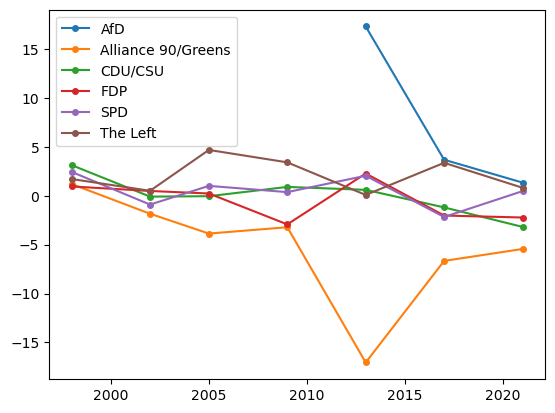

In [103]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in dv_d2v.groupby('party'):
    ax.plot(group.election, group.d2v_d2, marker='o',  ms=4, label=name)
ax.legend()

plt.show()

In [104]:
dv_d2v.to_csv('data/py_outputs/r&c_gen.csv', index=False)

#### Doc2Vec scaling - Germany, environment
 

In [105]:
manifesto_deu_rgr_env = manifesto_deu_rgr[manifesto_deu_rgr.code_extract.isin([410,416,501])].reset_index(drop=True)


In [106]:
manifesto_deu_rgr_env.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,text_cleaned,party_election,party_name
0,Tatsächlich hat die Bundesrepublik von der Glo...,Germany_1998_41113_41000,Germany,1998,41113,41000,410,right,Environment,tatsächlich bundesrepublik globalisierung prof...,Alliance 90/Greens_1998,Alliance 90/Greens
1,der Aufbau neuer Strukturen wird vernachlässig...,Germany_1998_41113_41000,Germany,1998,41113,41000,410,right,Environment,aufbau neuer strukturen vernachlässigt rahmen ...,Alliance 90/Greens_1998,Alliance 90/Greens
2,Sie haben die Wahl zwischen dem Erhalt unserer...,Germany_1998_41113_41600,Germany,1998,41113,41600,416,left,Environment,wahl erhalt unserer natürlichen lebensgrundlag...,Alliance 90/Greens_1998,Alliance 90/Greens
3,"Der Preis dafür ist hoch Sie betreibt, gegen d...",Germany_1998_41113_41600,Germany,1998,41113,41600,416,left,Environment,preis dafür hoch betreibt willen mehrheit bevö...,Alliance 90/Greens_1998,Alliance 90/Greens
4,Die ökologischen Kosten des Wachstums werden w...,Germany_1998_41113_41600,Germany,1998,41113,41600,416,left,Environment,ökologischen kosten wachstums weltweit spürbar...,Alliance 90/Greens_1998,Alliance 90/Greens


In [107]:
outputs_stream = phraseIterator(manifesto_deu_rgr_env,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [108]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_env, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [109]:
model.train(corpusIterator(manifesto_deu_rgr_env, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [110]:
embed_dict = d2v_reduct(model)

In [111]:
d2v_env = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_env.index.name = 'party_election'
d2v_env.reset_index(inplace=True)

In [112]:
d2v_env[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_env.iloc[:,1:])

In [113]:
d2v_env = d2v_env[['party_election','d2v_d1', 'd2v_d2']]

In [117]:
d2v_env[['party', 'election']] = d2v_env['party_election'].str.split('_', expand=True)
d2v_env.loc[:,'election'] = d2v_env['election'].astype(int)

In [118]:
d2v_env

,party_election,d2v_d1,d2v_d2,party,election
0,Alliance 90/Greens_1998,-6.171295,-0.333232,Alliance 90/Greens,1998
1,The Left_1998,6.974784,0.019864,The Left,1998
2,SPD_1998,7.344186,-0.000288,SPD,1998
3,FDP_1998,-2.015783,0.038610,FDP,1998
4,CDU/CSU_1998,7.575941,0.038527,CDU/CSU,1998
5,Alliance 90/Greens_2002,-8.377562,0.139628,Alliance 90/Greens,2002
6,The Left_2002,10.758410,0.088057,The Left,2002
7,SPD_2002,8.200392,0.049794,SPD,2002
8,FDP_2002,5.447646,0.057351,FDP,2002
9,CDU/CSU_2002,7.096150,0.015042,CDU/CSU,2002


In [119]:
d2v_env.to_csv('data/py_outputs/r&c_env.csv', index=False)

#### Doc2Vec scaling - Germany, decentralization    
 

In [121]:
manifesto_deu_rgr_regions = manifesto_deu_rgr[manifesto_deu_rgr.code_extract.isin([301,302,305])].reset_index(drop=True)


In [122]:
len(manifesto_deu_rgr_regions.code_extract)

1221

In [123]:
outputs_stream = phraseIterator(manifesto_deu_rgr_regions,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [124]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_regions, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [125]:
model.train(corpusIterator(manifesto_deu_rgr_regions, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [126]:
embed_dict = d2v_reduct(model)

In [128]:
d2v_regions = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_regions.index.name = 'party_election'
d2v_regions.reset_index(inplace=True)

In [129]:
d2v_regions[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_regions.iloc[:,1:])

In [131]:
d2v_regions = d2v_regions[['party_election','d2v_d1', 'd2v_d2']]
d2v_regions[['party', 'election']] = d2v_regions['party_election'].str.split('_', expand=True)
d2v_regions.loc[:,'election'] = d2v_regions['election'].astype(int)

In [132]:
d2v_regions

,party_election,d2v_d1,d2v_d2,party,election
0,Alliance 90/Greens_1998,-1.843681,-0.009586,Alliance 90/Greens,1998
1,The Left_1998,-3.647125,-0.010117,The Left,1998
2,SPD_1998,-7.676119,-0.018436,SPD,1998
3,FDP_1998,-2.301028,-0.013385,FDP,1998
4,CDU/CSU_1998,-4.999175,-0.012104,CDU/CSU,1998
5,Alliance 90/Greens_2002,1.175090,-0.008396,Alliance 90/Greens,2002
6,The Left_2002,-0.795053,-0.021103,The Left,2002
7,SPD_2002,1.279909,-0.015598,SPD,2002
8,FDP_2002,-0.249039,-0.001881,FDP,2002
9,CDU/CSU_2002,4.024425,-0.015331,CDU/CSU,2002


In [133]:
d2v_regions.to_csv('data/py_outputs/r&c_regions.csv', index=False)

#### Doc2Vec scaling - Germany, economy
 

In [134]:
manifesto_deu_rgr_econ = manifesto_deu_rgr[manifesto_deu_rgr.code_extract.isin([401,402,403,404,409,412,413,414])].reset_index(drop=True)


In [135]:
manifesto_deu_rgr_econ.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,text_cleaned,party_election,party_name
0,Mögliche Überschüsse wollen wir den Bürgerinne...,Germany_1998_41113_40100,Germany,1998,41113,40100,401,right,Economy,mögliche überschüsse bürgerinnen bürgern zurüc...,Alliance 90/Greens_1998,Alliance 90/Greens
1,Der Aufbau selbstverwalteter und genossenschaf...,Germany_1998_41113_40100,Germany,1998,41113,40100,401,right,Economy,aufbau selbstverwalteter genossenschaftlicher ...,Alliance 90/Greens_1998,Alliance 90/Greens
2,Für energieintensive Branchen wollen wir in di...,Germany_1998_41113_40200,Germany,1998,41113,40200,402,right,Economy,energieintensive branchen zeitraum anpassungsh...,Alliance 90/Greens_1998,Alliance 90/Greens
3,wirtschaftliche die durch Umlenkung von Subven...,Germany_1998_41113_40200,Germany,1998,41113,40200,402,right,Economy,wirtschaftliche umlenkung subventionen initiie...,Alliance 90/Greens_1998,Alliance 90/Greens
4,und die Wettbewerbsfähigkeit der Unternehmen v...,Germany_1998_41113_40200,Germany,1998,41113,40200,402,right,Economy,wettbewerbsfähigkeit unternehmen verbessert ha...,Alliance 90/Greens_1998,Alliance 90/Greens


In [136]:
outputs_stream = phraseIterator(manifesto_deu_rgr_econ,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [137]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_econ, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [138]:
model.train(corpusIterator(manifesto_deu_rgr_econ, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [139]:
embed_dict = d2v_reduct(model)

In [140]:
d2v_econ = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_econ.index.name = 'party_election'
d2v_econ.reset_index(inplace=True)

In [141]:
d2v_econ[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_econ.iloc[:,1:])

In [142]:
d2v_econ = d2v_econ[['party_election','d2v_d1', 'd2v_d2']]
d2v_econ[['party', 'election']] = d2v_econ['party_election'].str.split('_', expand=True)
d2v_econ.loc[:,'election'] = d2v_econ['election'].astype(int)

In [143]:
d2v_econ

,party_election,d2v_d1,d2v_d2,party,election
0,Alliance 90/Greens_1998,1.867923,-0.185266,Alliance 90/Greens,1998
1,The Left_1998,10.320865,0.064860,The Left,1998
2,SPD_1998,3.382898,0.023068,SPD,1998
3,FDP_1998,-4.699182,0.140781,FDP,1998
4,CDU/CSU_1998,8.758362,0.104508,CDU/CSU,1998
5,Alliance 90/Greens_2002,7.165476,0.003150,Alliance 90/Greens,2002
6,The Left_2002,8.047877,0.071524,The Left,2002
7,SPD_2002,6.161762,-0.013744,SPD,2002
8,FDP_2002,-1.544290,-0.296143,FDP,2002
9,CDU/CSU_2002,1.692410,-0.059221,CDU/CSU,2002


In [144]:
d2v_econ.to_csv('data/py_outputs/r&c_econ.csv', index=False)

#### Doc2Vec scaling - Germany, EU integration
 

In [145]:
manifesto_deu_rgr_eu = manifesto_deu_rgr[manifesto_deu_rgr.code_extract.isin([108,110])].reset_index(drop=True)


In [146]:
manifesto_deu_rgr_eu.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,text_cleaned,party_election,party_name
0,Mehr Demokratie und demokratische Kontrolle fo...,Germany_1998_41113_11000,Germany,1998,41113,11000,110,right,European integration,mehr demokratie demokratische kontrolle forder...,Alliance 90/Greens_1998,Alliance 90/Greens
1,Der Nachfolgevertrag von Amsterdam ist hinter ...,Germany_1998_41113_11000,Germany,1998,41113,11000,110,right,European integration,nachfolgevertrag amsterdam anspruch zurückgebl...,Alliance 90/Greens_1998,Alliance 90/Greens
2,Als europäische sozialistische Partei befürwor...,Germany_1998_41221_10800,Germany,1998,41221,10800,108,left,European integration,europäische sozialistische partei befürwortet ...,The Left_1998,The Left
3,"Europäische Einbettung, Die Europäische Union ...",Germany_1998_41420_10800,Germany,1998,41420,10800,108,left,European integration,europäische einbettung europäische union verän...,FDP_1998,FDP
4,Deshalb muß der EU-Vertrag zu einer Europäisch...,Germany_1998_41420_10800,Germany,1998,41420,10800,108,left,European integration,deshalb muß eu vertrag europäischen verfassung...,FDP_1998,FDP


In [147]:
outputs_stream = phraseIterator(manifesto_deu_rgr_eu,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [148]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_eu, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [149]:
model.train(corpusIterator(manifesto_deu_rgr_eu, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [150]:
embed_dict = d2v_reduct(model)

In [151]:
d2v_eu = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_eu.index.name = 'party_election'
d2v_eu.reset_index(inplace=True)

In [152]:
d2v_eu[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_eu.iloc[:,1:])

In [153]:
d2v_eu = d2v_eu[['party_election','d2v_d1', 'd2v_d2']]
d2v_eu[['party', 'election']] = d2v_eu['party_election'].str.split('_', expand=True)
d2v_eu.loc[:,'election'] = d2v_eu['election'].astype(int)

In [154]:
d2v_eu

,party_election,d2v_d1,d2v_d2,party,election
0,Alliance 90/Greens_1998,-7.930840,0.019284,Alliance 90/Greens,1998
1,The Left_1998,-10.995297,0.026493,The Left,1998
2,FDP_1998,-5.558533,0.005618,FDP,1998
3,Alliance 90/Greens_2002,-4.156391,-0.002953,Alliance 90/Greens,2002
4,The Left_2002,-5.763330,0.022400,The Left,2002
5,SPD_2002,-2.491133,-0.003091,SPD,2002
6,FDP_2002,1.323377,-0.015046,FDP,2002
7,CDU/CSU_2002,-6.122305,0.024485,CDU/CSU,2002
8,Alliance 90/Greens_2005,-1.675804,0.018686,Alliance 90/Greens,2005
9,The Left_2005,-6.643536,0.022454,The Left,2005


In [155]:
d2v_eu.to_csv('data/py_outputs/r&c_eu.csv', index=False)

#### Doc2Vec scaling - Germany, welfare
 

In [156]:
manifesto_deu_rgr_wf = manifesto_deu_rgr[manifesto_deu_rgr.code_extract.isin([503,504,505,701,702])].reset_index(drop=True)


In [157]:
manifesto_deu_rgr_wf.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,text_cleaned,party_election,party_name
0,"soziale Gerechtigkeit, und Gleichberechtigung ...",Germany_1998_41113_50300,Germany,1998,41113,50300,503,left,Social Welfare,soziale gerechtigkeit gleichberechtigung fraue...,Alliance 90/Greens_1998,Alliance 90/Greens
1,Die Steuerpolitik fördert die Umverteilung zug...,Germany_1998_41113_50300,Germany,1998,41113,50300,503,left,Social Welfare,steuerpolitik fördert umverteilung zugunsten u...,Alliance 90/Greens_1998,Alliance 90/Greens
2,"Wir wollen, daß Jugendliche in die Gestaltung ...",Germany_1998_41113_50300,Germany,1998,41113,50300,503,left,Social Welfare,jugendliche gestaltung heutigen gesellschaft z...,Alliance 90/Greens_1998,Alliance 90/Greens
3,ohne national und international die Kluft zwis...,Germany_1998_41113_50300,Germany,1998,41113,50300,503,left,Social Welfare,national international kluft arm reich aufzure...,Alliance 90/Greens_1998,Alliance 90/Greens
4,BÜNDNIS 90/DIE GRÜNEN setzen auf ein Wirtschaf...,Germany_1998_41113_50300,Germany,1998,41113,50300,503,left,Social Welfare,bündnis grünen setzen wirtschafts technologiek...,Alliance 90/Greens_1998,Alliance 90/Greens


In [158]:
outputs_stream = phraseIterator(manifesto_deu_rgr_wf,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [159]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_wf, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [160]:
model.train(corpusIterator(manifesto_deu_rgr_wf, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [161]:
embed_dict = d2v_reduct(model)

In [162]:
d2v_wf = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_wf.index.name = 'party_election'
d2v_wf.reset_index(inplace=True)

In [163]:
d2v_wf[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_wf.iloc[:,1:])

In [165]:
d2v_wf = d2v_wf[['party_election','d2v_d1', 'd2v_d2']]
d2v_wf[['party', 'election']] = d2v_wf['party_election'].str.split('_', expand=True)
d2v_wf.loc[:,'election'] = d2v_wf['election'].astype(int)

In [166]:
d2v_wf

,party_election,d2v_d1,d2v_d2,party,election
0,Alliance 90/Greens_1998,4.017097,-1.602306,Alliance 90/Greens,1998
1,The Left_1998,2.367895,-1.468333,The Left,1998
2,SPD_1998,4.754275,3.381052,SPD,1998
3,FDP_1998,1.983966,0.870121,FDP,1998
4,CDU/CSU_1998,-0.127499,8.370948,CDU/CSU,1998
5,Alliance 90/Greens_2002,-4.124950,-1.761202,Alliance 90/Greens,2002
6,The Left_2002,2.089926,0.039920,The Left,2002
7,SPD_2002,-0.348183,2.256796,SPD,2002
8,FDP_2002,-0.022917,-1.708602,FDP,2002
9,CDU/CSU_2002,1.599309,3.530588,CDU/CSU,2002


In [167]:
d2v_wf.to_csv('data/py_outputs/r&c_wf.csv', index=False)

#### Doc2Vec scaling - Germany, immigration
 

In [168]:
manifesto_deu_rgr_imm = manifesto_deu_rgr[manifesto_deu_rgr.code_extract.isin([601,602,607,608])].reset_index(drop=True)


In [169]:
manifesto_deu_rgr_imm.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,text_cleaned,party_election,party_name
0,Wir stellen uns der Verantwortung für die deut...,Germany_1998_41113_60200,Germany,1998,41113,60200,602,left,Immigration,stellen verantwortung deutsche geschichte setz...,Alliance 90/Greens_1998,Alliance 90/Greens
1,Erinnerungs- und Dokumentationsarbeit ist auch...,Germany_1998_41113_60200,Germany,1998,41113,60200,602,left,Immigration,erinnerungs dokumentationsarbeit vergessenen o...,Alliance 90/Greens_1998,Alliance 90/Greens
2,"Unser Umgang mit den Opfern ist Maßstab dafür,...",Germany_1998_41113_60200,Germany,1998,41113,60200,602,left,Immigration,umgang opfern maßstab dafür ddr unrecht bewert...,Alliance 90/Greens_1998,Alliance 90/Greens
3,Die bislang durch den Staat eingezogene Kirche...,Germany_1998_41113_60200,Germany,1998,41113,60200,602,left,Immigration,bislang staat eingezogene kirchensteuer mittel...,Alliance 90/Greens_1998,Alliance 90/Greens
4,Die Prostitution soll durch ihre Anerkennung a...,Germany_1998_41113_60200,Germany,1998,41113,60200,602,left,Immigration,prostitution anerkennung berufliche tätigkeit ...,Alliance 90/Greens_1998,Alliance 90/Greens


In [170]:
outputs_stream = phraseIterator(manifesto_deu_rgr_imm,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [171]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr_imm, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [172]:
model.train(corpusIterator(manifesto_deu_rgr_imm, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [173]:
embed_dict = d2v_reduct(model)

In [174]:
d2v_imm = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_imm.index.name = 'party_election'
d2v_imm.reset_index(inplace=True)

In [175]:
d2v_imm[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_imm.iloc[:,1:])

In [178]:
d2v_imm = d2v_imm[['party_election','d2v_d1', 'd2v_d2']]
d2v_imm[['party', 'election']] = d2v_imm['party_election'].str.split('_', expand=True)
d2v_imm.loc[:,'election'] = d2v_imm['election'].astype(int)

In [179]:
d2v_imm

,party_election,d2v_d1,d2v_d2,party,election
0,Alliance 90/Greens_1998,-3.986806,0.000122,Alliance 90/Greens,1998
1,The Left_1998,-5.689720,0.000320,The Left,1998
2,SPD_1998,-5.240545,0.000013,SPD,1998
3,FDP_1998,-0.348573,0.000046,FDP,1998
4,CDU/CSU_1998,-1.357765,0.004012,CDU/CSU,1998
5,Alliance 90/Greens_2002,-4.363965,0.000632,Alliance 90/Greens,2002
6,The Left_2002,-5.268252,-0.000196,The Left,2002
7,SPD_2002,-3.003208,0.000141,SPD,2002
8,FDP_2002,-0.214129,-0.009755,FDP,2002
9,CDU/CSU_2002,1.586905,-0.002277,CDU/CSU,2002


In [180]:
d2v_imm.to_csv('data/py_outputs/r&c_imm.csv', index=False)